Deep Learning
=============

Learning TensorBoard

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
%matplotlib inline
import time
%pylab
from IPython import display

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (400000, 28, 28) (400000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (400000, 28, 28, 1) (400000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Lets first define some functions.

In [6]:
def ph_train_data(batchsize, image_size, num_labels):
    return(tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels)),
               tf.placeholder(tf.float32, shape=(batch_size, num_labels))) 

In [7]:
def weights_pars(shape, std):
    return(tf.Variable(tf.truncated_normal(shape, stddev=std)))

In [8]:
def biases_pars(value, shape):
    return(tf.Variable(tf.constant(value, shape=shape)))

Function to run a session for a given graph and number of epochs

In [65]:
def runit(num_steps, graph, dirname):
    """
    This function takes the defined computational graph as input and then
    executes it for a given number of steps.
    """
    with tf.Session(graph=graph, config=tf.ConfigProto(device_count={"CPU":6}, inter_op_parallelism_threads=6, 
                                         intra_op_parallelism_threads=6)) as session:    
    #with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        train_writer = tf.summary.FileWriter(dirname + '/train' ,session.graph)
        test_writer = tf.summary.FileWriter(dirname + '/test') 
        print('Initialized')
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax2.set_ylim([70, 100])
        ax2.grid(which='major', axis='y')
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, is_training : True}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 50 == 0):
                minibatch_accuracy = session.run(batch_accuracy, feed_dict = feed_dict)
                validation_accuracy = session.run(valid_accuracy, feed_dict = {is_training : False})
                print('Minibatch accuracy: %.1f%%' % minibatch_accuracy)
                print('Validation accuracy: %.1f%%' % validation_accuracy)
                train_writer.add_summary(session.run(merged_summary, feed_dict = feed_dict), step)
                ax1.scatter(step, l, s=20, color="k")
                ax2.scatter(step, minibatch_accuracy, s=20, color="r", label="Minibatch")
                ax2.scatter(step, validation_accuracy, s=20, color="b", label="Validation")
                if (step == 0):
                    plt.legend(loc=4)
                    plt.suptitle(dirname[15:-1])
                display.clear_output(wait=True)
                display.display(plt.gcf())

        #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
        print('Test accuracy: %.1f%%' % session.run(test_accuracy, feed_dict={is_training : False}))

Defining computational graph, doing some hyper-parameter optimization.

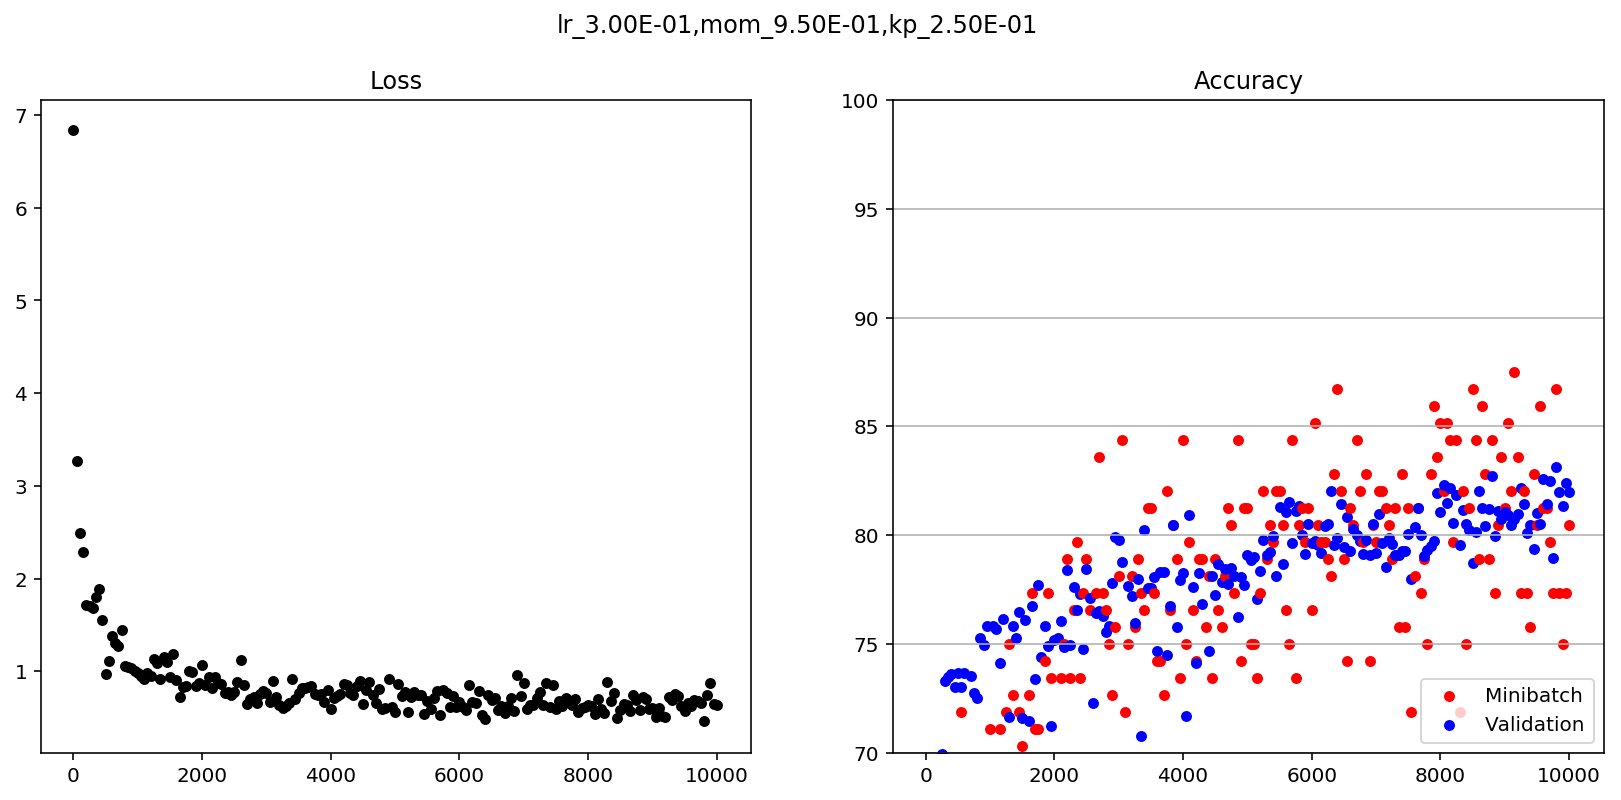

Test accuracy: 88.8%
CPU times: user 11h 18min 57s, sys: 2h 8min 9s, total: 13h 27min 6s
Wall time: 2h 46min 16s


In [69]:
%%time
batch_size = 128
patch_size1 = 5
patch_size2 = 4
patch_size3 = 3
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden = 1024
std = 0.1
nsteps = 10001
lrs = [0.05, 0.1, 0.2] # list of learning rates
moms = [0.8, 0.9, 0.95, 0.99] # list of momentums used in BN
kps = [0.75, 0.9, 1.0] # list of keep_probs used in dropout

for lr in lrs:
    for mom in moms:
        for kp in kps:
            print("Learning rate: ", lr)
            graph1 = tf.Graph()
            with graph1.as_default():
                # Input data.
                tf_train_dataset = tf.placeholder(
                tf.float32, shape=(batch_size, image_size, image_size, num_channels), name = 'x')
                tf.summary.image('input', tf_train_dataset, 3)
                tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels), name = 'labels')
                tf_valid_dataset = tf.constant(valid_dataset)
                tf_test_dataset = tf.constant(test_dataset)
                is_training = tf.placeholder(tf.bool)
        
                layer1_weights = weights_pars(shape = [patch_size1,patch_size1,num_channels,depth1], std=std)
                layer2_weights = weights_pars(shape = [patch_size2,patch_size2,depth1,depth2], std=std)
                layer3_weights = weights_pars(shape = [patch_size3,patch_size3,depth2,depth3], std=std)
                layer4_weights = weights_pars(shape = [image_size//4*image_size//4*depth3,num_hidden], std=std)
                layer5_weights = weights_pars(shape = [num_hidden, num_labels], std=std)
                layer5_biases = biases_pars(value = 0.1, shape=[num_labels])
                # Model.
                def model(data, reuse, dp):
                    with tf.name_scope("conv1"):
                        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
                        conv1_bn = tf.layers.batch_normalization(inputs=conv1, axis=-1, momentum=mom, epsilon=0.001, center=True, scale=True, training = is_training, name='conv1_bn', reuse = reuse)
                        act1 = tf.nn.relu(conv1_bn)
                        act1 = tf.cond(dp, lambda: tf.nn.dropout(act1, keep_prob=kp), lambda: act1)
                        tf.summary.histogram("Weights1", layer1_weights)
                        tf.summary.histogram("Activations1", act1)
                    with tf.name_scope("conv2"):
                        conv2 = tf.nn.conv2d(act1, layer2_weights, [1, 1, 1, 1], padding='SAME')
                        conv2_bn = tf.layers.batch_normalization(inputs=conv2, axis=-1, momentum=mom, epsilon=0.001, center=True, scale=True, training = is_training, name='conv2_bn', reuse = reuse)
                        act2 = tf.nn.relu(conv2_bn)
                        act2_mp = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                        act2_mp = tf.cond(dp, lambda: tf.nn.dropout(act2_mp, keep_prob=kp), lambda: act2_mp)
                        tf.summary.histogram("Weights2", layer2_weights)
                        tf.summary.histogram("Activations2", act2)
                        tf.summary.histogram("Activations2_mp", act2_mp)
                    with tf.name_scope("conv3"):
                        conv3 = tf.nn.conv2d(act2_mp, layer3_weights, [1, 2, 2, 1], padding='SAME')
                        conv3_bn = tf.layers.batch_normalization(inputs=conv3, axis=-1, momentum=mom, epsilon=0.001, center=True, scale=True, training = is_training, name='conv3_bn', reuse = reuse)
                        act3 = tf.nn.relu(conv3_bn)
                        act3 = tf.cond(dp, lambda: tf.nn.dropout(act3, keep_prob=kp), lambda: act3)
                        tf.summary.histogram("Weights3", layer3_weights)
                        tf.summary.histogram("Activations3", act3)
                    with tf.name_scope("fc1"):
                        shape = act3.get_shape().as_list()
                        reshape = tf.reshape(act3, [shape[0], shape[1] * shape[2] * shape[3]])
                        fc1 = tf.matmul(reshape, layer4_weights)
                        fc1_bn = tf.layers.batch_normalization(inputs=fc1, axis=-1, momentum=mom, epsilon=0.001, center=True, scale=True, training = is_training, name='fc1_bn', reuse = reuse)
                        act4 = tf.nn.relu(fc1_bn)
                        act4 = tf.cond(dp, lambda: tf.nn.dropout(act4, keep_prob=kp), lambda: act4)
                        tf.summary.histogram("Weights4", layer4_weights)
                        tf.summary.histogram("Activations4", act4)
                    with tf.name_scope("fc2"):
                        logits = tf.matmul(act4, layer5_weights) + layer5_biases
                        tf.summary.histogram("Weights5", layer5_weights)
                        tf.summary.histogram("Biases5", layer5_biases)
                        tf.summary.histogram("Logits", logits)
                    return(logits)
       
                # Training computation.
                logits = model(tf_train_dataset, reuse = None, dp = tf.constant(True))
                with tf.name_scope("loss"):
                    loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
                    tf.summary.scalar("loss", loss)
    
                # Optimizer.
                with tf.name_scope("optim"):
                    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                    with tf.control_dependencies(extra_update_ops):
                        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)
  
                # Predictions for the training, validation, and test data.
                train_prediction = tf.nn.softmax(logits)
                valid_prediction = tf.nn.softmax(model(tf_valid_dataset, reuse =True, dp = tf.constant(False)))
                test_prediction = tf.nn.softmax(model(tf_test_dataset, reuse = True, dp = tf.constant(False)))
            
                with tf.name_scope("batch_accuracy"):
                    batch_accuracy = 100 * tf.reduce_mean(tf.cast(tf.equal(tf.argmax(train_prediction, 1), tf.argmax(tf_train_labels, 1)), tf.float32))
                    tf.summary.scalar("batch_accuracy", batch_accuracy)
                with tf.name_scope("valid_accuracy"):
                    valid_accuracy = 100 * tf.reduce_mean(tf.cast(tf.equal(tf.argmax(valid_prediction, 1), tf.argmax(valid_labels.reshape(valid_labels.shape[0], num_labels), 1)), tf.float32))
                    tf.summary.scalar("valid_accuracy", valid_accuracy)
                with tf.name_scope("test_accuracy"):
                    test_accuracy = 100 * tf.reduce_mean(tf.cast(tf.equal(tf.argmax(test_prediction, 1), tf.argmax(test_labels.reshape(test_labels.shape[0], num_labels), 1)), tf.float32))
                    tf.summary.scalar("test_accuracy", test_accuracy)
                merged_summary = tf.summary.merge_all()
            # Run the model
            runit(num_steps=nsteps, graph=graph1, dirname = 'TensorBoard/BN/lr_%.2E,mom_%.2E,kp_%.2E/' % (lr, mom, kp))

By comparing results obtained by using different set of hyper-parameters in tensorboard, we found the following parameters to give best result:

lr = 0.3

mom = 0.95

kp = 0.8

Note that we ran another simulation by using dropouts in the fc layer and found kp = 0.8 in that case. If dropout was usedi n all layers, then we found that kp=1 (i.e. no dropout) gave best result.

For the final run, we increae the number of steps to 15001 and also make the final fc layer with 4096 neurons, and batch_size = 256.

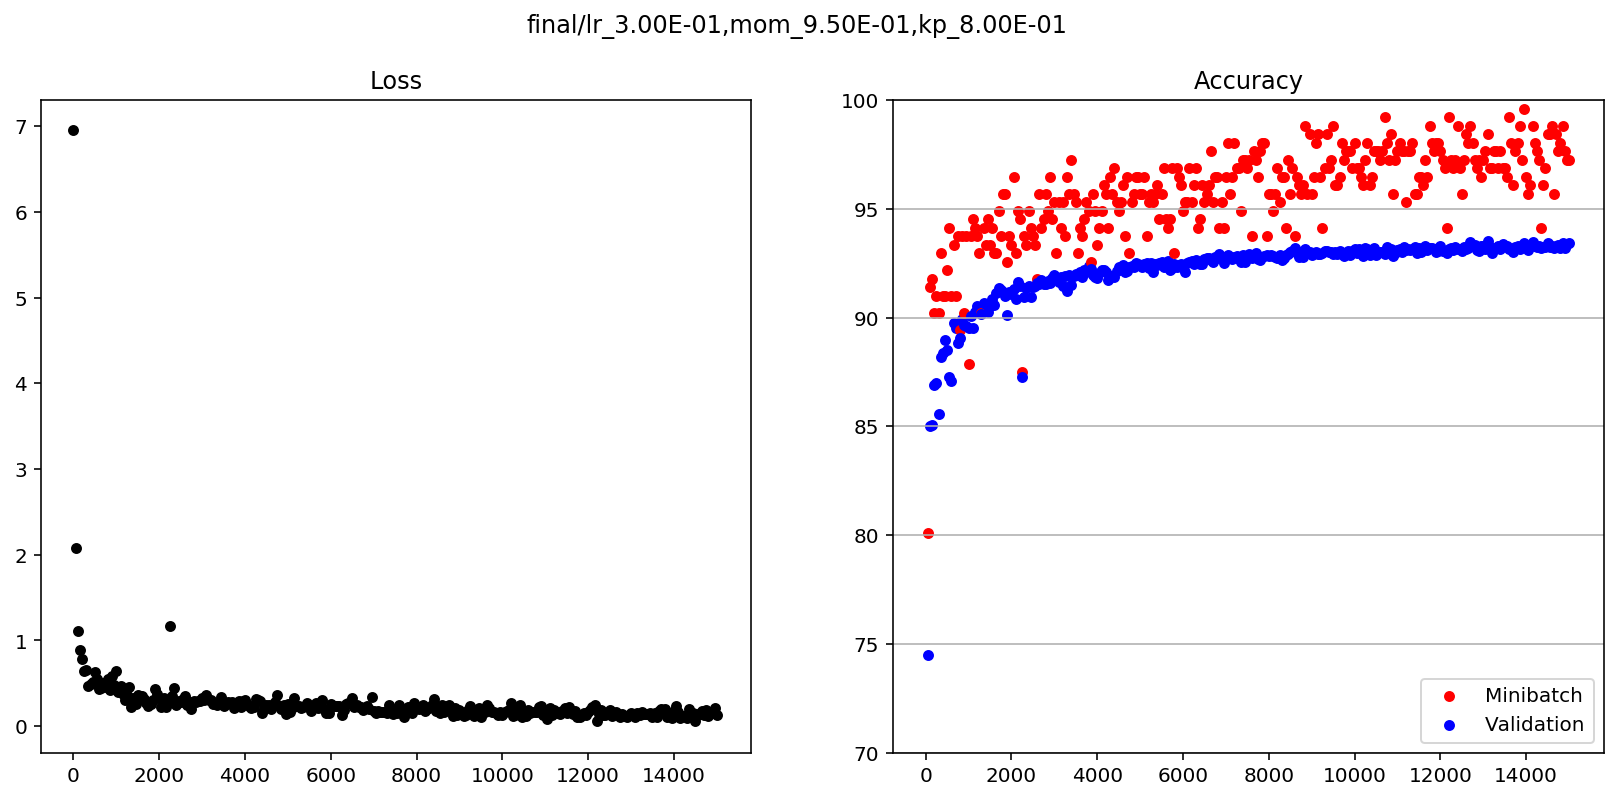

Test accuracy: 97.6%
CPU times: user 1d 5h 3min 54s, sys: 3h 29min 1s, total: 1d 8h 32min 55s
Wall time: 6h 1min 34s


In [73]:
%%time
batch_size = 256
patch_size1 = 5
patch_size2 = 4
patch_size3 = 3
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden = 4096
std = 0.1
nsteps = 15001
#lrs = [0.05, 0.1, 0.2]
#moms = [0.8, 0.9, 0.95, 0.99]
#kps = [0.75, 0.9, 1.0]
lrs = [0.3]
moms = [0.95]
kps = [0.8]

for lr in lrs:
    for mom in moms:
        for kp in kps:
            print("Learning rate: ", lr)
            graph1 = tf.Graph()
            with graph1.as_default():
                # Input data.
                tf_train_dataset = tf.placeholder(
                tf.float32, shape=(batch_size, image_size, image_size, num_channels), name = 'x')
                tf.summary.image('input', tf_train_dataset, 3)
                tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels), name = 'labels')
                tf_valid_dataset = tf.constant(valid_dataset)
                tf_test_dataset = tf.constant(test_dataset)
                is_training = tf.placeholder(tf.bool)
        
                layer1_weights = weights_pars(shape = [patch_size1,patch_size1,num_channels,depth1], std=std)
                layer2_weights = weights_pars(shape = [patch_size2,patch_size2,depth1,depth2], std=std)
                layer3_weights = weights_pars(shape = [patch_size3,patch_size3,depth2,depth3], std=std)
                layer4_weights = weights_pars(shape = [image_size//4*image_size//4*depth3,num_hidden], std=std)
                layer5_weights = weights_pars(shape = [num_hidden, num_labels], std=std)
                layer5_biases = biases_pars(value = 0.1, shape=[num_labels])
                # Model.
                def model(data, reuse, dp):
                    with tf.name_scope("conv1"):
                        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
                        conv1_bn = tf.layers.batch_normalization(inputs=conv1, axis=-1, momentum=mom, epsilon=0.001, center=True, scale=True, training = is_training, name='conv1_bn', reuse = reuse)
                        act1 = tf.nn.relu(conv1_bn)
                        #act1 = tf.cond(dp, lambda: tf.nn.dropout(act1, keep_prob=kp), lambda: act1)
                        tf.summary.histogram("Weights1", layer1_weights)
                        tf.summary.histogram("Activations1", act1)
                    with tf.name_scope("conv2"):
                        conv2 = tf.nn.conv2d(act1, layer2_weights, [1, 1, 1, 1], padding='SAME')
                        conv2_bn = tf.layers.batch_normalization(inputs=conv2, axis=-1, momentum=mom, epsilon=0.001, center=True, scale=True, training = is_training, name='conv2_bn', reuse = reuse)
                        act2 = tf.nn.relu(conv2_bn)
                        act2_mp = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                        #act2_mp = tf.cond(dp, lambda: tf.nn.dropout(act2_mp, keep_prob=kp), lambda: act2_mp)
                        tf.summary.histogram("Weights2", layer2_weights)
                        tf.summary.histogram("Activations2", act2)
                        tf.summary.histogram("Activations2_mp", act2_mp)
                    with tf.name_scope("conv3"):
                        conv3 = tf.nn.conv2d(act2_mp, layer3_weights, [1, 2, 2, 1], padding='SAME')
                        conv3_bn = tf.layers.batch_normalization(inputs=conv3, axis=-1, momentum=mom, epsilon=0.001, center=True, scale=True, training = is_training, name='conv3_bn', reuse = reuse)
                        act3 = tf.nn.relu(conv3_bn)
                        #act3 = tf.cond(dp, lambda: tf.nn.dropout(act3, keep_prob=kp), lambda: act3)
                        tf.summary.histogram("Weights3", layer3_weights)
                        tf.summary.histogram("Activations3", act3)
                    with tf.name_scope("fc1"):
                        shape = act3.get_shape().as_list()
                        reshape = tf.reshape(act3, [shape[0], shape[1] * shape[2] * shape[3]])
                        fc1 = tf.matmul(reshape, layer4_weights)
                        fc1_bn = tf.layers.batch_normalization(inputs=fc1, axis=-1, momentum=mom, epsilon=0.001, center=True, scale=True, training = is_training, name='fc1_bn', reuse = reuse)
                        act4 = tf.nn.relu(fc1_bn)
                        act4 = tf.cond(dp, lambda: tf.nn.dropout(act4, keep_prob=kp), lambda: act4)
                        tf.summary.histogram("Weights4", layer4_weights)
                        tf.summary.histogram("Activations4", act4)
                    with tf.name_scope("fc2"):
                        logits = tf.matmul(act4, layer5_weights) + layer5_biases
                        tf.summary.histogram("Weights5", layer5_weights)
                        tf.summary.histogram("Biases5", layer5_biases)
                        tf.summary.histogram("Logits", logits)
                    return(logits)
       
                # Training computation.
                logits = model(tf_train_dataset, reuse = None, dp = tf.constant(True))
                with tf.name_scope("loss"):
                    loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
                    tf.summary.scalar("loss", loss)
    
                # Optimizer.
                with tf.name_scope("optim"):
                    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                    with tf.control_dependencies(extra_update_ops):
                        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)
  
                # Predictions for the training, validation, and test data.
                train_prediction = tf.nn.softmax(logits)
                valid_prediction = tf.nn.softmax(model(tf_valid_dataset, reuse =True, dp = tf.constant(False)))
                test_prediction = tf.nn.softmax(model(tf_test_dataset, reuse = True, dp = tf.constant(False)))
            
                with tf.name_scope("batch_accuracy"):
                    batch_accuracy = 100 * tf.reduce_mean(tf.cast(tf.equal(tf.argmax(train_prediction, 1), tf.argmax(tf_train_labels, 1)), tf.float32))
                    tf.summary.scalar("batch_accuracy", batch_accuracy)
                with tf.name_scope("valid_accuracy"):
                    valid_accuracy = 100 * tf.reduce_mean(tf.cast(tf.equal(tf.argmax(valid_prediction, 1), tf.argmax(valid_labels.reshape(valid_labels.shape[0], num_labels), 1)), tf.float32))
                    tf.summary.scalar("valid_accuracy", valid_accuracy)
                with tf.name_scope("test_accuracy"):
                    test_accuracy = 100 * tf.reduce_mean(tf.cast(tf.equal(tf.argmax(test_prediction, 1), tf.argmax(test_labels.reshape(test_labels.shape[0], num_labels), 1)), tf.float32))
                    tf.summary.scalar("test_accuracy", test_accuracy)
                merged_summary = tf.summary.merge_all()
            # Run the model
            runit(num_steps=nsteps, graph=graph1, dirname = 'TensorBoard/BN_final/lr_%.2E,mom_%.2E,kp_%.2E/' % (lr, mom, kp))

Finally, we get the ***test accuracy of 97.6%***. This can be improved further by running longer, by having more neurons in fc layers, and perhaps adding more fc layers in the end.